In [1]:
%matplotlib inline


# Clustering text documents using k-means


This is an example showing how the scikit-learn can be used to cluster
documents by topics using a bag-of-words approach. This example uses
a scipy.sparse matrix to store the features instead of standard numpy arrays.

Two feature extraction methods can be used in this example:

  - TfidfVectorizer uses a in-memory vocabulary (a python dict) to map the most
    frequent words to features indices and hence compute a word occurrence
    frequency (sparse) matrix. The word frequencies are then reweighted using
    the Inverse Document Frequency (IDF) vector collected feature-wise over
    the corpus.

  - HashingVectorizer hashes word occurrences to a fixed dimensional space,
    possibly with collisions. The word count vectors are then normalized to
    each have l2-norm equal to one (projected to the euclidean unit-ball) which
    seems to be important for k-means to work in high dimensional space.

    HashingVectorizer does not provide IDF weighting as this is a stateless
    model (the fit method does nothing). When IDF weighting is needed it can
    be added by pipelining its output to a TfidfTransformer instance.

Two algorithms are demoed: ordinary k-means and its more scalable cousin
minibatch k-means.

Additionally, latent semantic analysis can also be used to reduce dimensionality
and discover latent patterns in the data. 

It can be noted that k-means (and minibatch k-means) are very sensitive to
feature scaling and that in this case the IDF weighting helps improve the
quality of the clustering by quite a lot as measured against the "ground truth"
provided by the class label assignments of the 20 newsgroups dataset.

This improvement is not visible in the Silhouette Coefficient which is small
for both as this measure seem to suffer from the phenomenon called
"Concentration of Measure" or "Curse of Dimensionality" for high dimensional
datasets such as text data. Other measures such as V-measure and Adjusted Rand
Index are information theoretic based evaluation scores: as they are only based
on cluster assignments rather than distances, hence not affected by the curse
of dimensionality.

Note: as k-means is optimizing a non-convex objective function, it will likely
end up in a local optimum. Several runs with independent random init might be
necessary to get a good convergence.



In [2]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
import pandas as pd
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, AgglomerativeClustering, SpectralClustering, AffinityPropagation, Birch, DBSCAN

import logging
from optparse import OptionParser
import sys
import os
from time import time

import numpy as np


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

op.add_option("-f")


(opts, args) = op.parse_args()
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

Load some categories from the training set


In [237]:
indir = '/home/user/projects/data_mining/clustering_cw/book_texts/one_line_text'
books_names = []
books_texts = []
for texts in os.listdir(indir):
    name, ex = os.path.splitext(texts)
    books_names.append(name)
    books_texts.append(open(indir + "/" + texts).read())

real_names= {'gap_-C0BAAAAQAAJ' : 'Dictionary of Greek and Roman Geography, Edited by William Smith, Vol II',
'gap_2X5KAAAAYAAJ' : 'The Works of Cornelius Tacitus, by Arthur Murphy, Vol V',
'gap_9ksIAAAAQAAJ' : 'The History of the Peloponnesian War, translated from the Greek of Thucydides, By William Smith, Vol II',
'gap_Bdw_AAAAYAAJ' : 'The History of Rome By Titus Liviusm, translated by George Baker, Vol I',
'gap_CSEUAAAAYAAJ' : 'The History of the Decline and Fall of The Roman Empire, by Edward Gibbon, Vol III',
'gap_CnnUAAAAMAAJ' : 'The Whole Genuie Works of Flavius Josephus, by William Whiston, Vol II',
'gap_DhULAAAAYAAJ' : 'The Description of Greece, by Pausanias, Vol III',
'gap_DqQNAAAAYAAJ' : 'LIVY , History of Rome, translated by George Baker, Vol III',
'gap_GIt0HMhqjRgC' : 'Gibbon\'s History of the Decline and Fall of The Roman Empire, by Thomas Bowdler, Vol IV',
'gap_IlUMAQAAMAAJ' : 'Gibbon\'s History of the Decline and Fall of the Roman Empire, by Thomas Bowdler, Vol II',
'gap_MEoWAAAAYAAJ' : 'The Historical Annals of Cornelius Tacitus, by Arthur Murphy, Vol I',
'gap_RqMNAAAAYAAJ' : 'LIVY , History of Rome, translated by George Baker, Vol V',
'gap_TgpMAAAAYAAJ' : 'The Genuie Works of Flavius Josephus, by William Whiston, Vol I',
'gap_VPENAAAAQAAJ' : 'The History of the Decline and Fall of The Roman Empire, by Edward Gibbon, Vol V',
'gap_WORMAAAAYAAJ' : 'The Histories of Caius Cornelius Tacitus, by William Seymour Tyler',
'gap_XmqHlMECi6kC' : 'The History of the Decline and Fall of The Roman Empire, by Edward Gibbon, Vol VI',
'gap_aLcWAAAAQAAJ' : 'The History of the Decline and Fall of The Roman Empire, by Edward Gibbon, Vol I',
'gap_dIkBAAAAQAAJ' : 'The History of Rome by Theoder Mommsen, translated by William P. Dickson, Vol III',
'gap_fnAMAAAAYAAJ' : 'The History of the Peloponnesian War by Thucydides, By William Smith, Vol I',
'gap_m_6B1DkImIoC' : 'Titus Livus, Roman History, by William Gordon',
'gap_ogsNAAAAIAAJ' : 'The Works of Josephus, by William Whiston, Vol IV',
'gap_pX5KAAAAYAAJ' : 'The Works of Cornelius Tacitus, by Arthur Murphy, Vol IV',
'gap_udEIAAAAQAAJ' : 'The First and Thirty-Third Books of Pliny\'s Natural History, by John Bostock',
'gap_y-AvAAAAYAAJ' : 'The Genuie Works of Flavius Josephus, by William Whiston, Vol III'}


_names= {
'gap_-C0BAAAAQAAJ' : 'Greek and Roman Geography Vol II',
'gap_2X5KAAAAYAAJ' : 'Cornelius Tacitus, Vol V',
'gap_9ksIAAAAQAAJ' : 'Peloponnesian War, Vol II',
'gap_Bdw_AAAAYAAJ' : 'LIVY, Vol I',
'gap_CSEUAAAAYAAJ' : 'Decline and Fall Rome, Vol III',
'gap_CnnUAAAAMAAJ' : 'Flavius Josephus, Vol II',
'gap_DhULAAAAYAAJ' : 'Description of Greece, Vol III',
'gap_DqQNAAAAYAAJ' : 'LIVY, Vol III',
'gap_GIt0HMhqjRgC' : 'Decline and Fall Rome, Vol IV',
'gap_IlUMAQAAMAAJ' : 'Decline and Fall Rome, Vol II',
'gap_MEoWAAAAYAAJ' : 'Cornelius Tacitus, Vol I',
'gap_RqMNAAAAYAAJ' : 'LIVY , Vol V',
'gap_TgpMAAAAYAAJ' : 'Flavius Josephus, Vol I',
'gap_VPENAAAAQAAJ' : 'Decline and Fall Rome, Vol V',
'gap_WORMAAAAYAAJ' : 'Cornelius Tacitus Caius',
'gap_XmqHlMECi6kC' : 'Decline and Fall Rome, Vol VI',
'gap_aLcWAAAAQAAJ' : 'Decline and Fall Rome, Vol I',
'gap_dIkBAAAAQAAJ' : 'Hist of Rome, Theoder Mommsen,, Vol III',
'gap_fnAMAAAAYAAJ' : 'Peloponnesian War, Vol I',
'gap_m_6B1DkImIoC' : 'LIVY, Roman History',
'gap_ogsNAAAAIAAJ' : 'Flavius Josephus, Vol IV',
'gap_pX5KAAAAYAAJ' : 'Cornelius Tacitus, Vol IV',
'gap_udEIAAAAQAAJ' : 'Natural History, Pliny',
'gap_y-AvAAAAYAAJ' : 'Flavius Josephus, Vol III'}

short_names= {
'gap_-C0BAAAAQAAJ' : 'Geography',
'gap_2X5KAAAAYAAJ' : 'Cornelius V',
'gap_9ksIAAAAQAAJ' : 'Pelop W. II',
'gap_Bdw_AAAAYAAJ' : 'LIVY I',
'gap_CSEUAAAAYAAJ' : 'Fall R. III',
'gap_CnnUAAAAMAAJ' : 'Flavius II',
'gap_DhULAAAAYAAJ' : 'Desc Gr.',
'gap_DqQNAAAAYAAJ' : 'LIVY III',
'gap_GIt0HMhqjRgC' : 'Fall R. IV',
'gap_IlUMAQAAMAAJ' : 'Fall R. II',
'gap_MEoWAAAAYAAJ' : 'Cornelius I',
'gap_RqMNAAAAYAAJ' : 'LIVY  V',
'gap_TgpMAAAAYAAJ' : 'Flavius I',
'gap_VPENAAAAQAAJ' : 'Fall R. V',
'gap_WORMAAAAYAAJ' : 'Cornelius',
'gap_XmqHlMECi6kC' : 'Fall R. VI',
'gap_aLcWAAAAQAAJ' : 'Fall R. I',
'gap_dIkBAAAAQAAJ' : 'Hist Rome',
'gap_fnAMAAAAYAAJ' : 'Pelop W. I',
'gap_m_6B1DkImIoC' : 'LIVY',
'gap_ogsNAAAAIAAJ' : 'Flavius IV',
'gap_pX5KAAAAYAAJ' : 'Cornelius IV',
'gap_udEIAAAAQAAJ' : 'Natural His.',
'gap_y-AvAAAAYAAJ' : 'Flavius III'}

In [4]:
print (books_names)

['gap_ogsNAAAAIAAJ', 'gap_9ksIAAAAQAAJ', 'gap_y-AvAAAAYAAJ', 'gap_TgpMAAAAYAAJ', 'gap_pX5KAAAAYAAJ', 'gap_aLcWAAAAQAAJ', 'gap_GIt0HMhqjRgC', 'gap_fnAMAAAAYAAJ', 'gap_m_6B1DkImIoC', 'gap_MEoWAAAAYAAJ', 'gap_IlUMAQAAMAAJ', 'gap_DqQNAAAAYAAJ', 'gap_-C0BAAAAQAAJ', 'gap_WORMAAAAYAAJ', 'gap_CnnUAAAAMAAJ', 'gap_XmqHlMECi6kC', 'gap_2X5KAAAAYAAJ', 'gap_Bdw_AAAAYAAJ', 'gap_VPENAAAAQAAJ', 'gap_dIkBAAAAQAAJ', 'gap_CSEUAAAAYAAJ', 'gap_udEIAAAAQAAJ', 'gap_RqMNAAAAYAAJ', 'gap_DhULAAAAYAAJ']


In [5]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))


labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(
                                   stop_words='english', non_negative=True,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(
                                       stop_words='english',
                                       non_negative=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
    
data_file = open("/home/user/projects/data_mining/clustering_cw/testing/text/00000023.txt","r")
X = vectorizer.fit_transform(books_texts)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories
Extracting features from the training dataset using a sparse vectorizer
done in 6.961659s
n_samples: 24, n_features: 41553



In [6]:
clusters = [[4, 9, 13, 16], [8, 11, 17, 22], [1, 7], [23], [12], [21], [19], [5, 6, 10, 15, 18, 20], [0, 2, 3, 14]]
labels_temp = []
for i, cluster in enumerate(clusters):
    for book_i in cluster:
        labels_temp.append([book_i,i])
labels_temp.sort()
labels = []
for ind, clust in labels_temp:
      labels.append(clust)
print(labels)

[8, 2, 8, 8, 0, 7, 7, 2, 1, 0, 7, 1, 4, 0, 8, 7, 0, 1, 7, 6, 7, 5, 1, 3]


Do the actual clustering


In [217]:
n_clusters=7
vectorizer = CountVectorizer(max_df=0.5,min_df=2, stop_words='english', analyzer = 'word') 
#vectorizer = HashingVectorizer(stop_words='english', non_negative=False, norm='l2', binary=False, analyzer = 'word')
#vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english', norm='l2', analyzer = 'word')

X = vectorizer.fit_transform(books_texts)
print("n_samples: %d, n_features: %d" % X.shape)
print(X.todense())
#terms = vectorizer.get_feature_names()

ac = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)
ac.fit(X.todense())

#order_centroids = ac.cluster_centers_.argsort()[:, ::-1]
names_list = []
for i in range(np.unique(ac.labels_).shape[0]):
    #print("Cluster %d:" % i, end='')
    #for ind in order_centroids[i, :20]:
    #    print(' %s' % terms[ind], end='')
    indices = [a for a, x in enumerate(ac.labels_ ) if x == i]
    #print()
    #print ("Books in cluster %d :" % len(indices), end='')
    names_list_temp = []
    for ind in indices:        
        names_list_temp.append([ind,books_names[ind]])
        #print(' %s' % books_names[ind], end='')
    names_list.append(names_list_temp)
    #print()
    #print()

X.todense()
#print("Books in cluster:")
#for i in range(np.unique(ac.labels_).shape[0]):
#    print("Cluster %d:" % i)
#    for ind, key in names_list[i]:
#        print("|%s|[%d]  %s" % (key,ind, real_names.get(key)))



n_samples: 24, n_features: 41553
[[ 3  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  1  1  1]
 [ 2  0  0 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 3  0  1 ...,  1  4 17]]


matrix([[ 3,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 2,  0,  0, ...,  0,  0,  0],
        ..., 
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 3,  0,  1, ...,  1,  4, 17]])

In [218]:
pd.DataFrame(X.todense())

,0,1,2,3,4,5,6,7,8,9,...,41543,41544,41545,41546,41547,41548,41549,41550,41551,41552
0,3,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,3,0,0,0,1,1,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,9,0,0,0,0,0,0,0,0,1,...,1,1,0,0,6,11,2,1,0,0
6,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#vectorizer = CountVectorizer(max_df=0.5,min_df=2, stop_words='english', analyzer = 'word')
#vectorizer = HashingVectorizer(stop_words='english', non_negative=False, norm='l2', binary=False, analyzer = 'word')
vectorizer = TfidfVectorizer(max_df=0.4,min_df=2, stop_words='english', norm='l1', analyzer = 'word')

X = vectorizer.fit_transform(books_texts)
print("n_samples: %d, n_features: %d" % X.shape)
print()
terms = vectorizer.get_feature_names()

ac = MeanShift()
ac.fit(X.todense())

#order_centroids = ac.cluster_centers_.argsort()[:, ::-1]
names_list = []
for i in range(np.unique(ac.labels_).shape[0]):
    #print("Cluster %d:" % i, end='')
    #for ind in order_centroids[i, :20]:
    #    print(' %s' % terms[ind], end='')
    indices = [a for a, x in enumerate(ac.labels_ ) if x == i]
    #print()
    #print ("Books in cluster %d :" % len(indices), end='')
    names_list_temp = []
    for ind in indices:        
        names_list_temp.append([ind,books_names[ind]])
        #print(' %s' % books_names[ind], end='')
    names_list.append(names_list_temp)
    #print()
    #print()


print("Books in cluster:")
for i in range(np.unique(ac.labels_).shape[0]):
    print("Cluster %d:" % i)
    for ind, key in names_list[i]:
        print("|%s|[%d]  %s" % (key,ind, real_names.get(key)))

print(ac.labels_)
print(np.unique(ac.labels_))
print(len(np.unique(ac.labels_)))
vectorizer.get_params()

n_samples: 24, n_features: 38775

Books in cluster:
Cluster 0:
|gap_ogsNAAAAIAAJ|[0]  The Works of Josephus, by William Whiston, Vol IV
|gap_y-AvAAAAYAAJ|[2]  The Genuie Works of Flavius Josephus, by William Whiston, Vol III
|gap_TgpMAAAAYAAJ|[3]  The Genuie Works of Flavius Josephus, by William Whiston, Vol I
|gap_pX5KAAAAYAAJ|[4]  The Works of Cornelius Tacitus, by Arthur Murphy, Vol IV
|gap_aLcWAAAAQAAJ|[5]  The History of the Decline and Fall of The Roman Empire, by Edward Gibbon, Vol I
|gap_GIt0HMhqjRgC|[6]  Gibbon's History of the Decline and Fall of The Roman Empire, by Thomas Bowdler, Vol IV
|gap_fnAMAAAAYAAJ|[7]  The History of the Peloponnesian War by Thucydides, By William Smith, Vol I
|gap_m_6B1DkImIoC|[8]  Titus Livus, Roman History, by William Gordon
|gap_IlUMAQAAMAAJ|[10]  Gibbon's History of the Decline and Fall of the Roman Empire, by Thomas Bowdler, Vol II
|gap_DqQNAAAAYAAJ|[11]  LIVY , History of Rome, translated by George Baker, Vol III
|gap_-C0BAAAAQAAJ|[12]  Dicti

{'analyzer': 'word',
 'binary': False,
 'decode_error': u'strict',
 'dtype': numpy.int64,
 'encoding': u'utf-8',
 'input': u'content',
 'lowercase': True,
 'max_df': 0.4,
 'max_features': None,
 'min_df': 2,
 'ngram_range': (1, 1),
 'norm': 'l1',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': u'(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [230]:
n_clusters=7
#vectorizer = CountVectorizer(max_df=0.5,min_df=2, stop_words='english', analyzer = 'word') 
#vectorizer = HashingVectorizer(stop_words='english', non_negative=False, norm='l2', binary=False, analyzer = 'word')
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', norm='l2', analyzer = 'word')

X = vectorizer.fit_transform(books_texts)
print("n_samples: %d, n_features: %d" % X.shape)
print()
#terms = vectorizer.get_feature_names()

ac = AgglomerativeClustering(n_clusters=n_clusters, affinity ='l2', linkage='average')
ac.fit(X.todense())

#order_centroids = ac.cluster_centers_.argsort()[:, ::-1]
names_list = []
for i in range(np.unique(ac.labels_).shape[0]):
    #print("Cluster %d:" % i, end='')
    #for ind in order_centroids[i, :20]:
    #    print(' %s' % terms[ind], end='')
    indices = [a for a, x in enumerate(ac.labels_ ) if x == i]
    #print()
    #print ("Books in cluster %d :" % len(indices), end='')
    names_list_temp = []
    for ind in indices:        
        names_list_temp.append([ind,books_names[ind]])
        #print(' %s' % books_names[ind], end='')
    names_list.append(names_list_temp)
    #print()
    #print()


#print("Books in cluster:")
#for i in range(np.unique(ac.labels_).shape[0]):
#    print("Cluster %d:" % i)
#    for ind, key in names_list[i]:
#        print("|%s|[%d]  %s" % (key,ind, real_names.get(key)))
        

#'AggloClu with n_clusters: 7 affinity: cosine linkage: average'
#'CountVec max_df: 0.5 min_df: 2 analyzer: word lowercase: True '
ac.labels_ = [3, 1, 3, 3, 0, 6, 6, 1, 5, 0, 6, 5, 2, 0, 3, 6, 0, 5, 6, 2, 6, 4, 5, 1]

n_samples: 24, n_features: 41553



['--Flavius IV', '--Pelop W. II', '--Flavius III', '--Flavius I', '--Cornelius IV', '--Fall R. I', '--Fall R. IV', '--Pelop W. I', '--LIVY', '--Cornelius I', '--Fall R. II', '--LIVY III', '--Geography', '--Cornelius', '--Flavius II', '--Fall R. VI', '--Cornelius V', '--LIVY I', '--Fall R. V', '--Hist Rome', '--Fall R. III', '--Natural His.', '--LIVY  V', '--Desc Gr.']


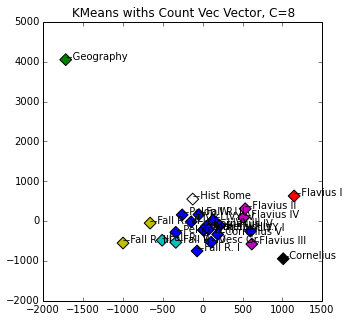

In [269]:
#'vector_cfg': 'TfidfVe max_df: 0.5 min_df: 2 analyzer: word lowercase: True norm: l2 sublinear_tf:False'
#AggloClu with n_clusters: 7 affinity: euclidean linkage: average'
#vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', norm='l2', analyzer = 'word', lowercase = True, sublinear_tf = False)
#vector = 'Tfidf Vec'
#algo = 'AggloClu'
#ac.labels_ = [6, 2, 6, 6, 0, 5, 5, 2, 1, 0, 5, 1, 4, 0, 6, 5, 0, 1, 5, 4, 5, 3, 1, 2]

#'CountVec max_df: 0.5 min_df: 2 analyzer: word lowercase: True '
#'KMeans with n_clusters: 8 max_iter: 100 init: k-means++ algorithm: elkan tol: 0.0001',
#vectorizer = CountVectorizer(max_df=0.5,min_df=2, stop_words='english', analyzer = 'word', lowercase = True) 
vector = 'Count Vec'
algo = 'KMeans'
ac.labels_ = [4, 0, 4, 2, 0, 0, 3, 0, 0, 0, 0, 0, 1, 6, 4, 5, 0, 0, 3, 7, 5, 0, 0, 0]

# 'KMeans with n_clusters: 8 max_iter: 300 init: random algorithm: full tol: 0.1'
#' TfidfVe max_df: 0.5 min_df: 2 analyzer: word lowercase: True norm: l2 sublinear_tf:False
#vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', norm='l2', analyzer = 'word', lowercase = True, sublinear_tf = False)
#vector = 'TfidfVe Vec'
#algo = 'KMeans'
#ac.labels_ = [7, 2, 7, 7, 1, 0, 0, 2, 4, 1, 0, 4, 3, 1, 7, 0, 1, 4, 0, 3, 0, 5, 4, 6]

#'AggloClu with n_clusters: 9 affinity: cosine linkage: average'
# 'CountVec max_df: 0.5 min_df: 2 analyzer: word lowercase: True '
#vectorizer = CountVectorizer(max_df=0.5,min_df=2, stop_words='english', analyzer = 'word', lowercase = True) 
#vector = 'Count Vec'
#algo = 'AggloClu'
#ac.labels_ = [7, 5, 7, 7, 3, 6, 6, 5, 2, 3, 6, 2, 0, 1, 7, 6, 1, 2, 6, 0, 6, 4, 2, 8]

X = vectorizer.fit_transform(books_texts)
books_names_real = ["--"+short_names.get(key) for key in books_names ]
print(books_names_real) 
color_arr = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', '0.65']
colors = [color_arr[label] for label in ac.labels_]
mds = manifold.MDS(n_components = 2, max_iter=50, n_init=1)
Y = mds.fit_transform(X.todense())
#Y = manifold.Isomap(n_neighbors = (len(np.unique(ac.labels_)) - 2 ), n_components = 2).fit_transform(X.todense())
fig = plt.figure(figsize=(5, 5))
title = '%s withs %s Vector, C=%s' %(algo,vector,len(np.unique(ac.labels_)))
plt.title(title)
plt.scatter(Y[:, 0], Y[:, 1],  c=colors, marker='D', label="6", s=70)
for i, txt in enumerate(books_names_real):
    plt.annotate(txt, (Y[:, 0][i],Y[:, 1][i]))

In [227]:

ac.labels_ = [8, 3, 8, 8, 2, 5, 5, 3, 6, 2, 5, 6, 4, 1, 8, 5, 1, 6, 5, 4, 5, 0, 6,7]
#ac.labels_ = [0, 4, 0, 0, 6, 2, 2, 4, 5, 6, 2, 5, 1, 7, 0, 2, 6, 5, 2, 1, 2, 8, 5,3]
names_list = []
for i in range(np.unique(ac.labels_).shape[0]):
    #print("Cluster %d:" % i, end='')
    #for ind in order_centroids[i, :20]:
    #    print(' %s' % terms[ind], end='')
    indices = [a for a, x in enumerate(ac.labels_ ) if x == i]
    #print()
    #print ("Books in cluster %d :" % len(indices), end='')
    names_list_temp = []
    for ind in indices:        
        names_list_temp.append([ind,books_names[ind]])
        #print(' %s' % books_names[ind], end='')
    names_list.append(names_list_temp)
    #print()
    #print()


#print("Books in cluster:")
#for i in range(np.unique(ac.labels_).shape[0]):
#    print("Cluster %d:" % i)
#    for ind, key in names_list[i]:
#        print("|%s|[%d]  %s" % (key,ind, real_names.get(key)))
        

def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [(int(i[:2], 16)/255.0, int(i[2:4], 16)/255.0, int(i[4:], 16)/255.0) for i in colors]

#color_arr = get_spaced_colors(len(np.unique(ac.labels_))-1)
color_arr = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', '0.5']
markers_arr = [",", "o", "v", "^", "<", ">", "1","*"]
markers = {'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', None: 'nothing', ' ': 'nothing', '': 'nothing'}
colors = [color_arr[label] for label in ac.labels_]
#markers = [markers_arr[label] for label in ac.labels_]
print(len(markers.keys()))
#print (ac.labels_)
print(colors)
mds = manifold.MDS(n_components = 2, max_iter=50, n_init=10)
Y = mds.fit_transform(X.todense())
markers = [0, 1, 2, 3, 4, 'D', 6, 7, 8, 's', '|', 11, 'None', 'P', 9, 'x', 'X', None, 5, '_', '^', ' ', 'd', 'h', '+', '*', ',', 'o', '.', '1', 'p', '3', '2', '4', 'H', 'v', '', '8', 10, '<', '>']

fig, axs = plt.subplots(11,4, figsize=(15, 40), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i, marker in enumerate (markers):
   # plt.scatter(data_point[1], data_point[0], c=colors[ind], marker='H')
    print(marker)
    print(type(marker))
    #if type(marker) != str: marker=str(marker)
    try:
        axs[i].set_title(marker)
        axs[i].scatter(Y[:, 0], Y[:, 1],  c=colors, marker=marker)
    except (AssertionError, ValueError):
        continue


In [86]:
clusters = [[4, 9, 13, 16], [8, 11, 17, 22], [1, 7], [23], [12], [21], [19], [5, 6, 10, 15, 18, 20], [0, 2, 3, 14]]
print("Books in cluster:")
for i, cluster in enumerate(clusters):
    print("Cluster %d:" % i)
    for book_i in cluster:
        print("|%s[%d]  %s" % (books_names[book_i], book_i, real_names.get(books_names[book_i])))

Books in cluster:
Cluster 0:
|gap_pX5KAAAAYAAJ[4]  The Works of Cornelius Tacitus, by Arthur Murphy, Vol IV
|gap_MEoWAAAAYAAJ[9]  The Historical Annals of Cornelius Tacitus, by Arthur Murphy, Vol I
|gap_WORMAAAAYAAJ[13]  The Histories of Caius Cornelius Tacitus, by William Seymour Tyler
|gap_2X5KAAAAYAAJ[16]  The Works of Cornelius Tacitus, by Arthur Murphy, Vol V
Cluster 1:
|gap_m_6B1DkImIoC[8]  Titus Livus, Roman History, by William Gordon
|gap_DqQNAAAAYAAJ[11]  LIVY , History of Rome, translated by George Baker, Vol III
|gap_Bdw_AAAAYAAJ[17]  The History of Rome By Titus Liviusm, translated by George Baker, Vol I
|gap_RqMNAAAAYAAJ[22]  LIVY , History of Rome, translated by George Baker, Vol V
Cluster 2:
|gap_9ksIAAAAQAAJ[1]  The History of the Peloponnesian War, translated from the Greek of Thucydides, By William Smith, Vol II
|gap_fnAMAAAAYAAJ[7]  The History of the Peloponnesian War by Thucydides, By William Smith, Vol I
Cluster 3:
|gap_DhULAAAAYAAJ[23]  The Description of Greece,

In [ ]:
list(enumerate(clusters))

In [ ]:
ac.labels_

In [ ]:
print(ac.labels_)

In [ ]:
km.labels_

In [ ]:
print(km.labels_)

In [ ]:
label1 = [6, 2, 6, 6, 0, 5, 5, 2, 1, 0, 5, 1, 4, 0, 6, 5, 0, 1, 5, 4, 5, 3, 1, 4]
label2 = [0, 0, 0, 0, 5, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 1, 0]

print (metrics.adjusted_rand_score(label1, label2))
print (metrics.normalized_mutual_info_score(label1, label2))
print (metrics.mutual_info_score(label1, label2))
print (metrics.adjusted_mutual_info_score(label1, label2))
print (metrics.homogeneity_score(label1, label2))  
print (metrics.completeness_score(label1, label2)) 
print (metrics.v_measure_score(label1, label2))
print (metrics.homogeneity_completeness_v_measure(label1, label2))
print (metrics.fowlkes_mallows_score(label1, label2))
print (metrics.silhouette_score(X.todense(), km.labels_, metric='euclidean'))
print (metrics.calinski_harabaz_score(X.todense(), km.labels_))


In [ ]:
n_clusters=7
#vectorizer = CountVectorizer(max_df=0.5,min_df=2, stop_words='english', analyzer = 'word') 
#vectorizer = HashingVectorizer(stop_words='english', non_negative=False, norm='l2', binary=False, analyzer = 'word')
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', norm='l2', analyzer = 'word')

X = vectorizer.fit_transform(books_texts)
print("n_samples: %d, n_features: %d" % X.shape)
print()
#terms = vectorizer.get_feature_names()

ac = AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=15, affinity='euclidean');
ac.fit(X.todense())

#order_centroids = ac.cluster_centers_.argsort()[:, ::-1]
names_list = []
for i in range(np.unique(ac.labels_).shape[0]):
    #print("Cluster %d:" % i, end='')
    #for ind in order_centroids[i, :20]:
    #    print(' %s' % terms[ind], end='')
    indices = [a for a, x in enumerate(ac.labels_ ) if x == i]
    #print()
    #print ("Books in cluster %d :" % len(indices), end='')
    names_list_temp = []
    for ind in indices:        
        names_list_temp.append([ind,books_names[ind]])
        #print(' %s' % books_names[ind], end='')
    names_list.append(names_list_temp)
    #print()
    #print()


print("Books in cluster:")
for i in range(np.unique(ac.labels_).shape[0]):
    print("Cluster %d:" % i)
    for ind, key in names_list[i]:
        print("|%s|[%d]  %s" % (key,ind, real_names.get(key)))

In [ ]:
n_clusters=7
#vectorizer = CountVectorizer(max_df=0.5,min_df=2, stop_words='english', analyzer = 'word') 
#vectorizer = HashingVectorizer(stop_words='english', non_negative=False, norm='l2', binary=False, analyzer = 'word')
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', norm='l2', analyzer = 'word')

X = vectorizer.fit_transform(books_texts)
print("n_samples: %d, n_features: %d" % X.shape)
print()
#terms = vectorizer.get_feature_names()

ac = Birch(threshold=0.5, branching_factor=50, n_clusters=7)
ac.fit(X.todense())

#order_centroids = ac.cluster_centers_.argsort()[:, ::-1]
names_list = []
for i in range(np.unique(ac.labels_).shape[0]):
    #print("Cluster %d:" % i, end='')
    #for ind in order_centroids[i, :20]:
    #    print(' %s' % terms[ind], end='')
    indices = [a for a, x in enumerate(ac.labels_ ) if x == i]
    #print()
    #print ("Books in cluster %d :" % len(indices), end='')
    names_list_temp = []
    for ind in indices:        
        names_list_temp.append([ind,books_names[ind]])
        #print(' %s' % books_names[ind], end='')
    names_list.append(names_list_temp)
    #print()
    #print()


print("Books in cluster:")
for i in range(np.unique(ac.labels_).shape[0]):
    print("Cluster %d:" % i)
    for ind, key in names_list[i]:
        print("|%s|[%d]  %s" % (key,ind, real_names.get(key)))

target_lab = [6, 2, 6, 6, 0, 5, 5, 2, 1, 0, 5, 1, 4, 0, 6, 5, 0, 1, 5, 4, 5, 3, 1, 2]
result_lab = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
metrics_num = [metrics.adjusted_rand_score(target_lab, result_lab), #perect fit is 1.0
                      metrics.normalized_mutual_info_score(target_lab, result_lab),  #perfect fit is 1.0
                      metrics.mutual_info_score(target_lab, result_lab), #perfect fit is 1.0
                      metrics.adjusted_mutual_info_score(target_lab, result_lab), #perfect fit is 1.0
                      metrics.homogeneity_score(target_lab, result_lab), #perfect fit is 1.0
                      metrics.completeness_score(target_lab, result_lab), #perfect fit is 1.0
                      metrics.v_measure_score(target_lab, result_lab), #perfect fit is 1.0
                      #metrics.homogeneity_completeness_v_measure(target_lab, result_lab),
                      metrics.fowlkes_mallows_score(target_lab, result_lab), #perfect fit is 1.0
                      metrics.silhouette_score(X.todense(), result_lab, metric='euclidean'), #the higher the better
                      metrics.calinski_harabaz_score(X.todense(), result_lab)]

In [ ]:
n_clusters=7
#vectorizer = CountVectorizer(max_df=0.5,min_df=2, stop_words='english', analyzer = 'word') 
#vectorizer = HashingVectorizer(stop_words='english', non_negative=False, norm='l2', binary=False, analyzer = 'word')
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', norm='l2', analyzer = 'word')

X = vectorizer.fit_transform(books_texts)
print("n_samples: %d, n_features: %d" % X.shape)
print()
#terms = vectorizer.get_feature_names()

ac = DBSCAN(eps=0.5, min_samples=2, metric='euclidean', algorithm='ball_tree', leaf_size=30, p=1)
ac.fit(X.todense())

#order_centroids = ac.cluster_centers_.argsort()[:, ::-1]
names_list = []
for i in range(np.unique(ac.labels_).shape[0]):
    #print("Cluster %d:" % i, end='')
    #for ind in order_centroids[i, :20]:
    #    print(' %s' % terms[ind], end='')
    indices = [a for a, x in enumerate(ac.labels_ ) if x == i]
    #print()
    #print ("Books in cluster %d :" % len(indices), end='')
    names_list_temp = []
    for ind in indices:        
        names_list_temp.append([ind,books_names[ind]])
        #print(' %s' % books_names[ind], end='')
    names_list.append(names_list_temp)
    #print()
    #print()


print("Books in cluster:")
for i in range(np.unique(ac.labels_).shape[0]):
    print("Cluster %d:" % i)
    for ind, key in names_list[i]:
        print("|%s|[%d]  %s" % (key,ind, real_names.get(key)))

In [ ]:
n_clusters=8
#vectorizer = CountVectorizer(max_df=0.5,min_df=2, stop_words='english', analyzer = 'word') 
#vectorizer = HashingVectorizer(stop_words='english', non_negative=False, norm='l2', binary=False, analyzer = 'word')
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', norm='l2', analyzer = 'word')

X = vectorizer.fit_transform(books_texts)
print("n_samples: %d, n_features: %d" % X.shape)
print()
#terms = vectorizer.get_feature_names()

ac = SpectralClustering(n_clusters=n_clusters, eigen_solver=None, random_state=None, n_init=10, gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol=0.0, assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=1)
ac.fit(X.todense())

#order_centroids = ac.cluster_centers_.argsort()[:, ::-1]
names_list = []
for i in range(np.unique(ac.labels_).shape[0]):
    #print("Cluster %d:" % i, end='')
    #for ind in order_centroids[i, :20]:
    #    print(' %s' % terms[ind], end='')
    indices = [a for a, x in enumerate(ac.labels_ ) if x == i]
    #print()
    #print ("Books in cluster %d :" % len(indices), end='')
    names_list_temp = []
    for ind in indices:        
        names_list_temp.append([ind,books_names[ind]])
        #print(' %s' % books_names[ind], end='')
    names_list.append(names_list_temp)
    #print()
    #print()


print("Books in cluster:")
for i in range(np.unique(ac.labels_).shape[0]):
    print("Cluster %d:" % i)
    for ind, key in names_list[i]:
        print("|%s|[%d]  %s" % (key,ind, real_names.get(key)))

In [ ]:
ac.labels_